<a href="https://colab.research.google.com/github/ngtht71/ML-Childmind/blob/main/ChildMind_KTT_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Model improvements
**Model improvements are shown in the notebook and annotated with [IMPROVEMENT] blocks**

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Data Preprocessing

In [ ]:
# function to read data file
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [ ]:
# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [ ]:
print(train.shape)
train.head()

(3960, 82)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(test.shape)
test.head()

(20, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(sample.shape)
sample.head()

(20, 2)


,id,sii
0,00008ff9,0
1,000fd460,1
2,00105258,2
3,00115b9f,3
4,0016bb22,0


## Visualization data in train

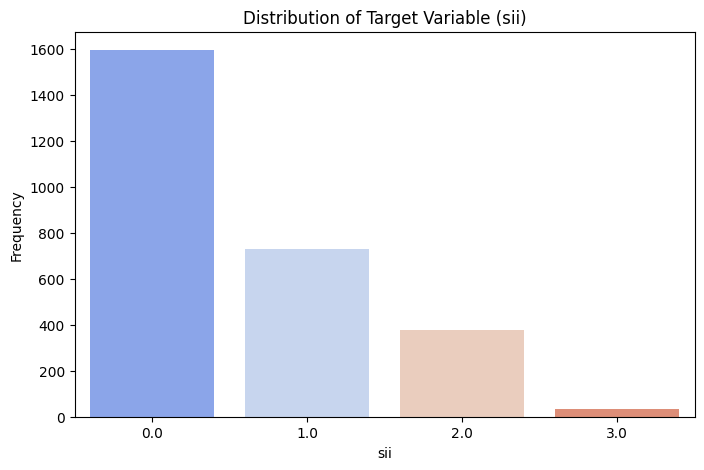

In [ ]:
# (Bar Chart)
plt.figure(figsize=(8, 5))
sns.countplot(x=train['sii'], palette='coolwarm')
plt.title('Distribution of Target Variable (sii)')
plt.xlabel('sii')
plt.ylabel('Frequency')
plt.show()

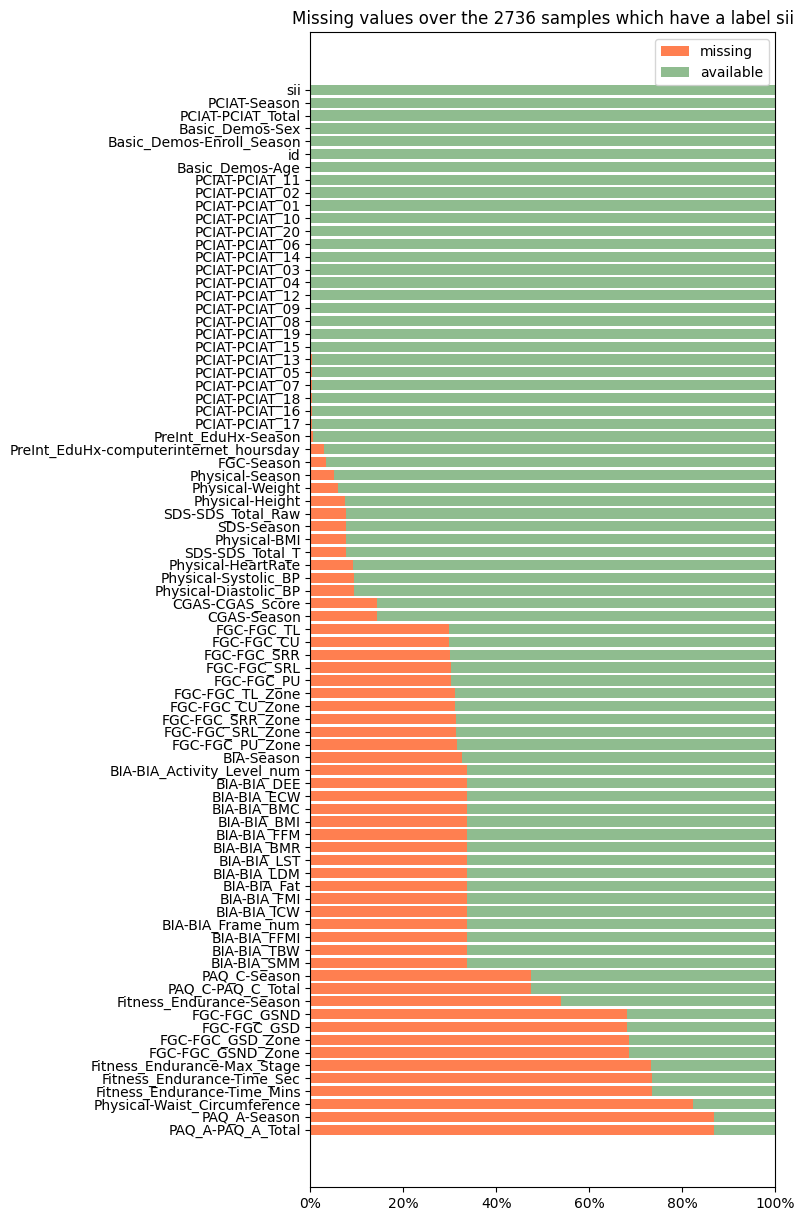

In [ ]:
# Keep samples with non-null values in column 'sii'
supervised_usable = train.dropna(subset=['sii'])

# Calculate the number of missing values and the missing data rate for each column
missing_count = supervised_usable.isnull().sum().reset_index()
missing_count.columns = ['feature', 'null_count']
missing_count['null_ratio'] = missing_count['null_count'] / len(supervised_usable)
missing_count = missing_count.sort_values('null_count', ascending=False)

# Draw a horizontal bar chart showing the ratio of missing and available data
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a label sii')

# Missing part (coral color)
plt.barh(np.arange(len(missing_count)),
         missing_count['null_ratio'],
         color='coral', label='missing')

# Available part (darkseagreen color)
plt.barh(np.arange(len(missing_count)),
         1 - missing_count['null_ratio'],
         left=missing_count['null_ratio'],
         color='darkseagreen', label='available')

# Customize y and x axis display
plt.yticks(np.arange(len(missing_count)), missing_count['feature'])
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

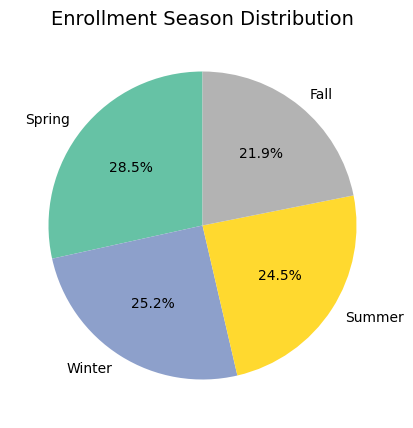

In [ ]:
# (Pie Chart) for 'Basic_Demos-Enroll_Season' column
plt.figure(figsize=(5, 5))
train['Basic_Demos-Enroll_Season'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    cmap='Set2',
)
plt.title('Enrollment Season Distribution', fontsize=14)
plt.ylabel('')  # Remove the label on y axis
plt.show()

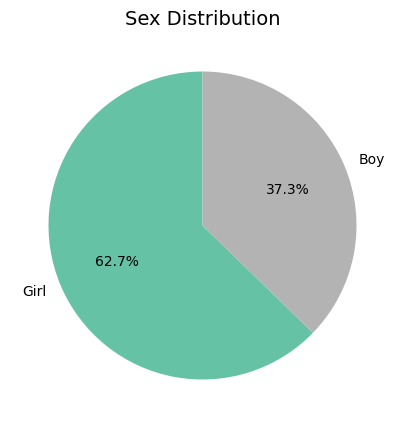

In [ ]:
# Pie Chart for 'Basic_Demos-Sex' column
plt.figure(figsize=(5, 5))  # Change size of chart
train['Basic_Demos-Sex'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    cmap='Set2',
    labels=['Girl', 'Boy'],  # Label for each part
)
plt.title('Sex Distribution', fontsize=14)
plt.ylabel('')               # Remove the label on y axis
plt.show()

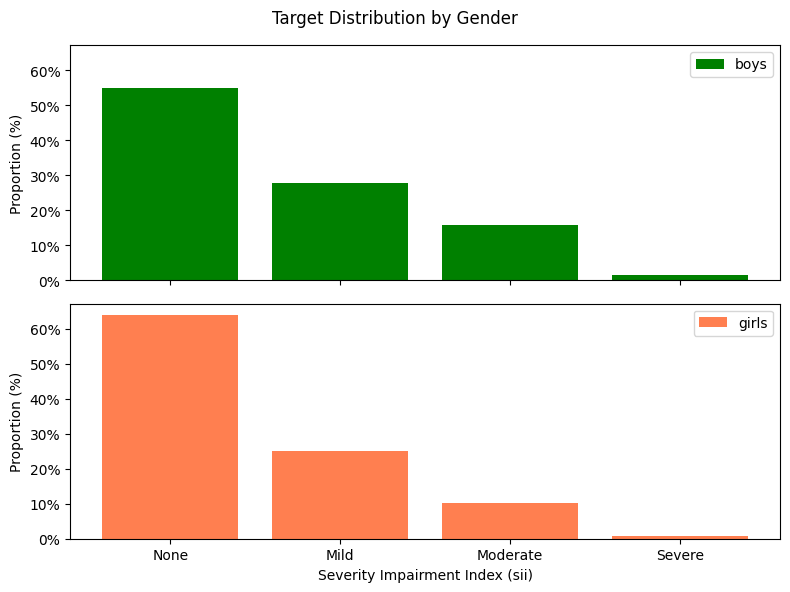

In [ ]:
# sii distribution chart by gender

# initialize target_labels
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

# create figure và subplots
_, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))

for sex in range(2):
    ax = axs.ravel()[sex]

    filtered = train[train['Basic_Demos-Sex'] == sex]

    vc = filtered['sii'].value_counts(normalize=True)

    ax.bar(vc.index,
           vc.values,
           color=['green', 'coral'][sex],
           label=['boys', 'girls'][sex])

    # Set labels and axes
    ax.set_xticks(np.arange(len(target_labels)))        # Set position on x-axis
    ax.set_xticklabels(target_labels)                   # set label for x-axis
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('Proportion (%)')
    ax.legend()

# set title and label for x-axis
plt.suptitle('Target Distribution by Gender')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.tight_layout()
plt.show()


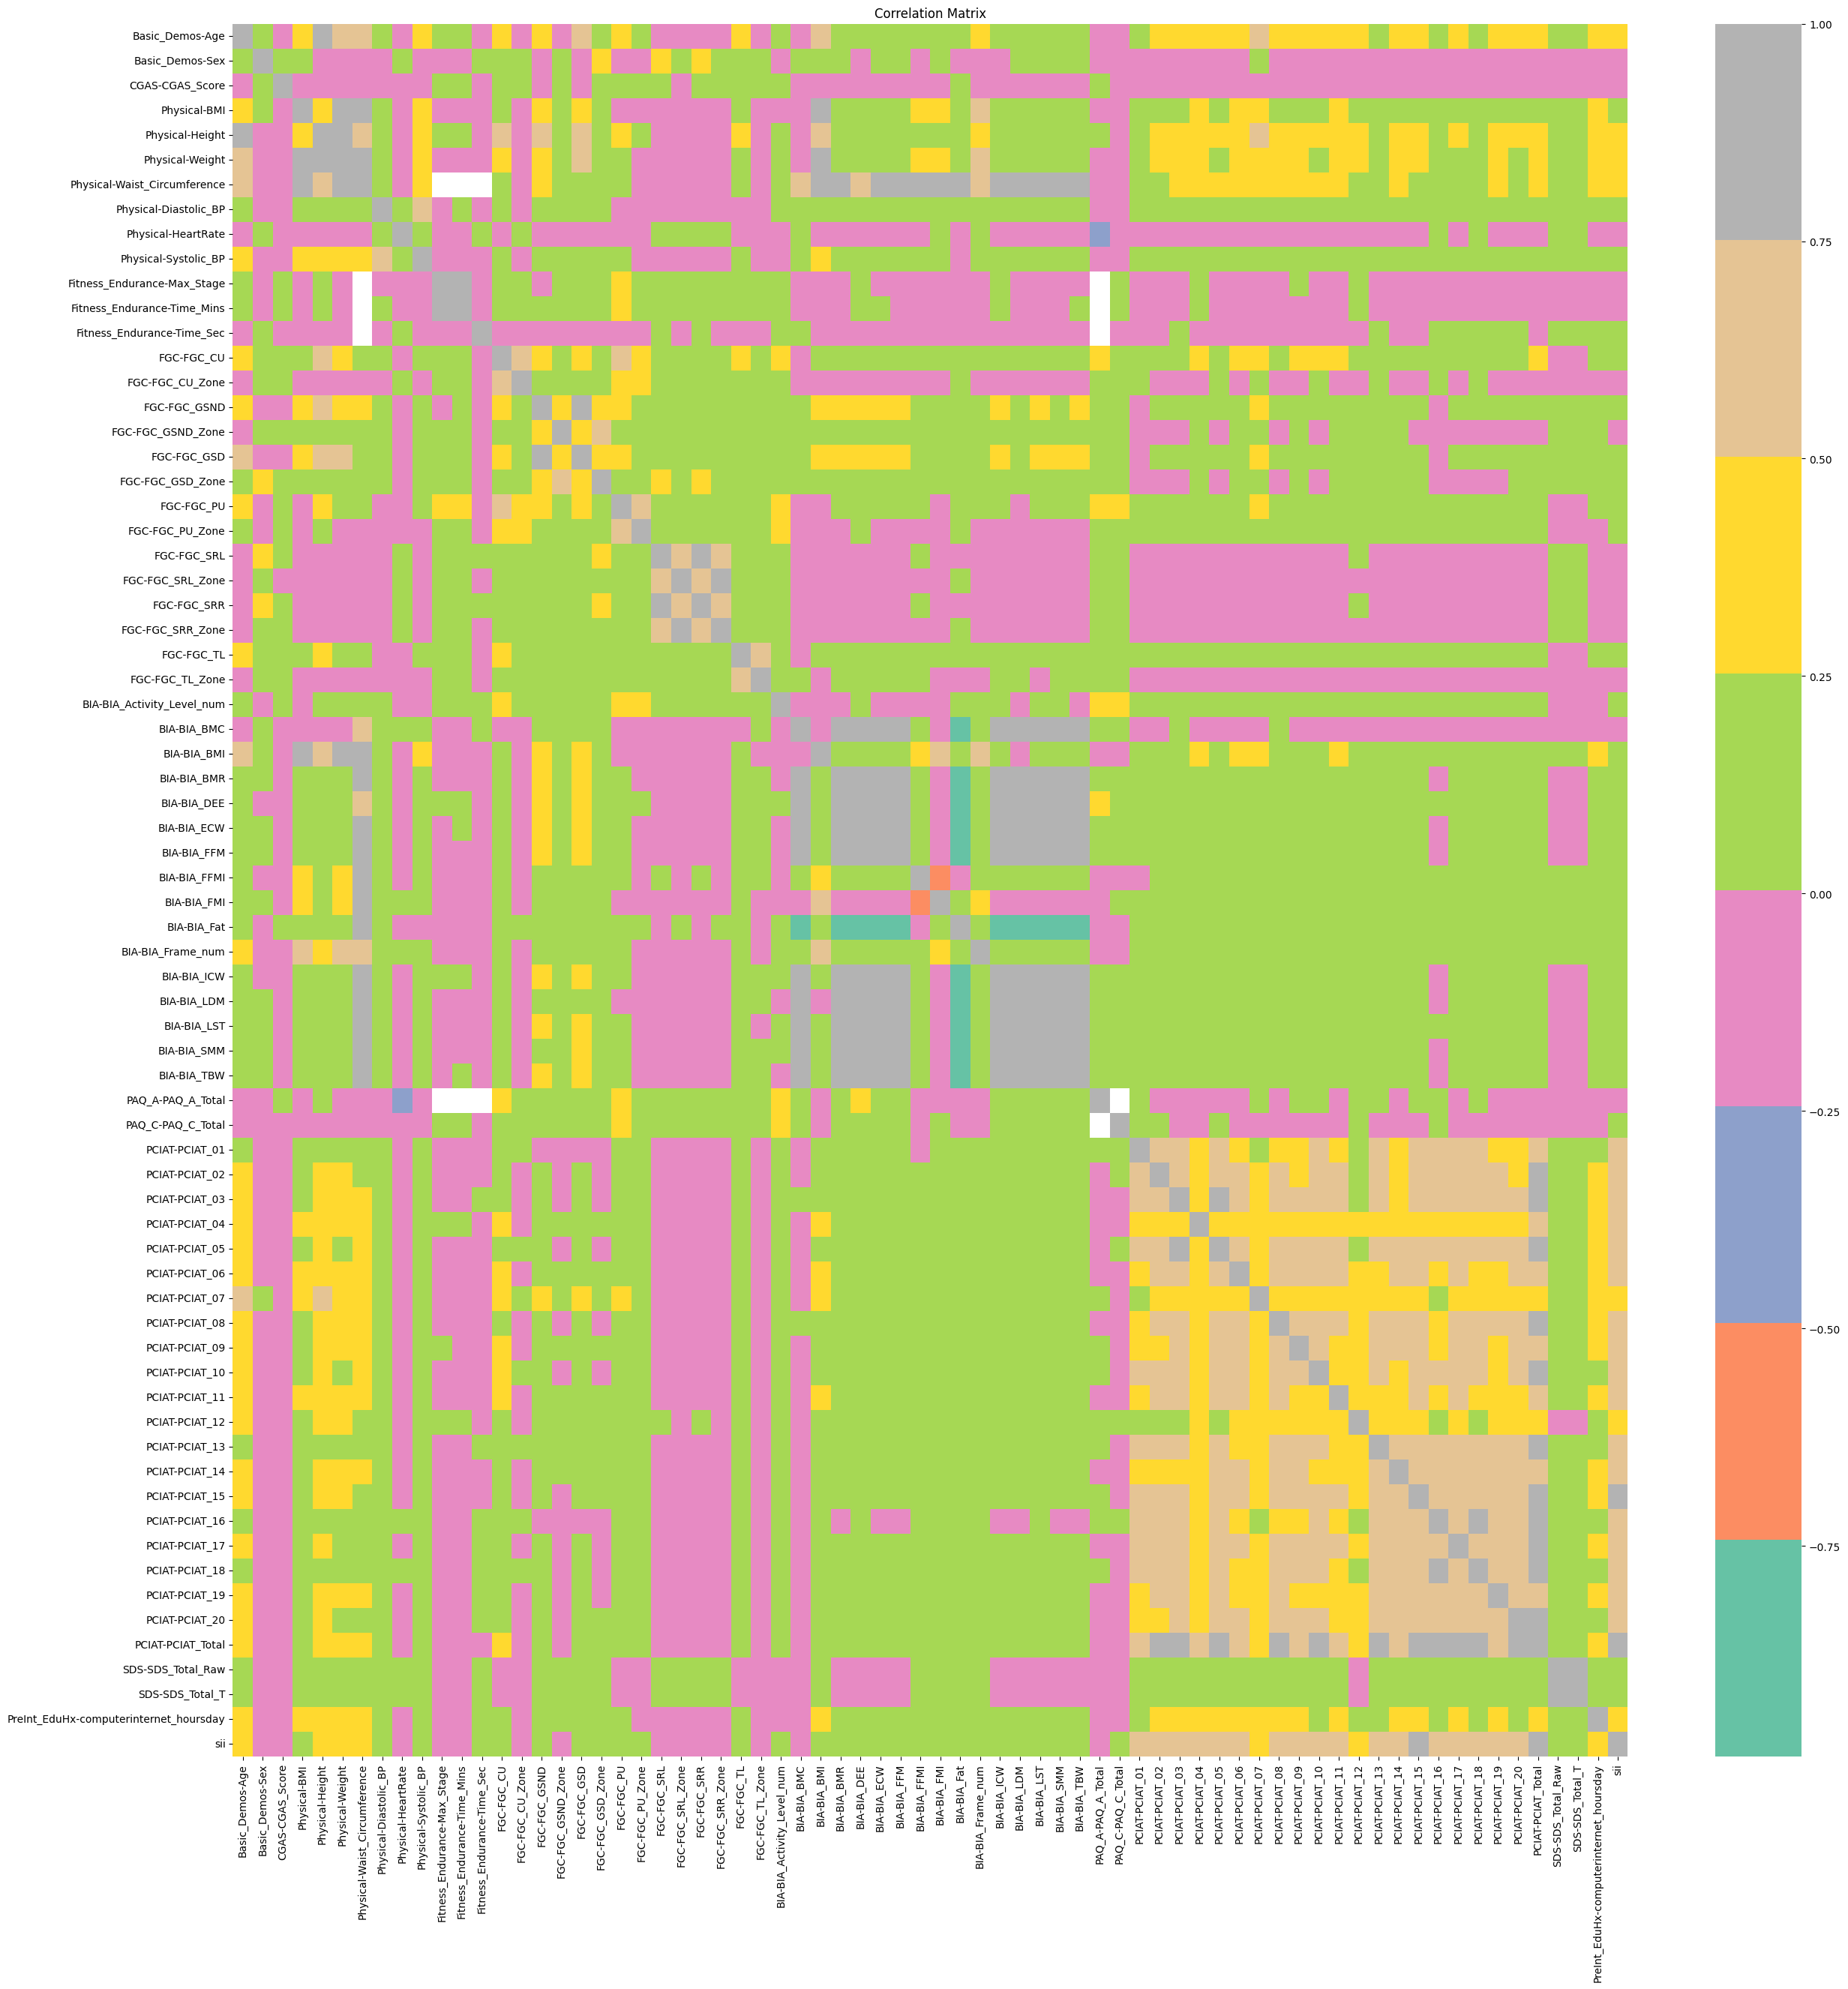

In [ ]:
# get numeric column
numeric_data = train.select_dtypes(include=['float64', 'int64'])

# correlation matrix
correlation_matrix = numeric_data.corr()

# Heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=False, cmap='Set2')
plt.title('Correlation Matrix')
plt.show()


## Merge Data

In [ ]:
# Load time series data
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


In [ ]:
print(train_ts.shape)
train_ts.head()

(996, 97)


,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,...,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,...,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,...,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,...,6.134459,89.976074,0.0,2502.000000,6000.0,8.639500e+13,7.0,4.0,72.0,b2987a65
4,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,...,2.774382,89.300034,0.0,1046.800049,4199.0,8.601500e+13,7.0,4.0,76.0,7b8842c3


In [ ]:
print(test_ts.shape)
test_ts.head()

(2, 97)


,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,...,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,00115b9f
1,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,...,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,001f3379


In [ ]:
# Filter data to get features before merging training set, test with time series
feature_col = test.columns.tolist()
feature_col.remove("id")          # remove 'id' column
feature_col.append("sii")
print(feature_col)
print("Số đặc điểm là", len(feature_col))

['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total

In [ ]:
# merge data train, test với time series
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
train = train.dropna(thresh=10, axis=0)                     #
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [ ]:
print(train.shape)
train.head()

(3340, 177)


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0


In [ ]:
print(test.shape)
test.head()

(20, 154)


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.25,4188.5,8.611000e+13,7.0,3.0,85.0
4,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Read data time series
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

In [ ]:
print(time_series_cols)
print(len(time_series_cols))

['stat_0', 'stat_1', 'stat_2', 'stat_3', 'stat_4', 'stat_5', 'stat_6', 'stat_7', 'stat_8', 'stat_9', 'stat_10', 'stat_11', 'stat_12', 'stat_13', 'stat_14', 'stat_15', 'stat_16', 'stat_17', 'stat_18', 'stat_19', 'stat_20', 'stat_21', 'stat_22', 'stat_23', 'stat_24', 'stat_25', 'stat_26', 'stat_27', 'stat_28', 'stat_29', 'stat_30', 'stat_31', 'stat_32', 'stat_33', 'stat_34', 'stat_35', 'stat_36', 'stat_37', 'stat_38', 'stat_39', 'stat_40', 'stat_41', 'stat_42', 'stat_43', 'stat_44', 'stat_45', 'stat_46', 'stat_47', 'stat_48', 'stat_49', 'stat_50', 'stat_51', 'stat_52', 'stat_53', 'stat_54', 'stat_55', 'stat_56', 'stat_57', 'stat_58', 'stat_59', 'stat_60', 'stat_61', 'stat_62', 'stat_63', 'stat_64', 'stat_65', 'stat_66', 'stat_67', 'stat_68', 'stat_69', 'stat_70', 'stat_71', 'stat_72', 'stat_73', 'stat_74', 'stat_75', 'stat_76', 'stat_77', 'stat_78', 'stat_79', 'stat_80', 'stat_81', 'stat_82', 'stat_83', 'stat_84', 'stat_85', 'stat_86', 'stat_87', 'stat_88', 'stat_89', 'stat_90', 'stat_91

In [ ]:
#Get the saved feature above - run only once to avoid duplicating
featuresCols = feature_col
print("Before add time series, there are", len(featuresCols),"features.")
featuresCols += time_series_cols
# print(featuresCols)
print("After add time series, there are ",len(featuresCols), "features.")

Before add time series, there are 59 features.
After add time series, there are  155 features.


In [ ]:
#Filter the train table, taking only the columns in featuresCols, and delete rows with undefined sii
train = train[featuresCols]
train = train.dropna(subset=['sii'])
print(train.shape)
train.head()

(2736, 155)


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0


In [ ]:
#Filter columns with data type string to change to categorical
data_dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
data_dictionary = data_dictionary[["Field", "Type"]]
filtered_data = data_dictionary[data_dictionary['Type'] == 'str']

#Filter columns not in the featuresCols list
filtered_data = filtered_data[filtered_data['Field'].isin(featuresCols)]

print(filtered_data)
filtered_data.shape

                        Field Type
1   Basic_Demos-Enroll_Season  str
4                 CGAS-Season  str
6             Physical-Season  str
14   Fitness_Endurance-Season  str
18                 FGC-Season  str
33                 BIA-Season  str
50               PAQ_A-Season  str
52               PAQ_C-Season  str
76                 SDS-Season  str
79        PreInt_EduHx-Season  str


(10, 2)

In [ ]:
category_list = filtered_data['Field'].tolist()
print(category_list)

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']


In [ ]:
#Convert NaN values ​​to 'Missing' and convert data type to category
def update(df):
    global category_list
    for c in category_list:
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

In [ ]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,Missing,NaN,Fall,14.035590,48.0,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0


In [ ]:
#Create a function that maps string values ​​to numeric strings
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in category_list:
    #If the column is already an integer, no remapping is required.
    if train[col].dtype.kind in 'i':
        print(f"{col} is already integer. Skipping mapping.")
        continue

    mapping = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    print("Train: ", col, "have the map ", mapping)
    print("Test: ", col, "have the map ", mapping_test)
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

Train:  Basic_Demos-Enroll_Season have the map  {'Fall': 0, 'Summer': 1, 'Winter': 2, 'Spring': 3}
Test:  Basic_Demos-Enroll_Season have the map  {'Fall': 0, 'Summer': 1, 'Winter': 2, 'Spring': 3}
Train:  CGAS-Season have the map  {'Winter': 0, 'Missing': 1, 'Fall': 2, 'Summer': 3, 'Spring': 4}
Test:  CGAS-Season have the map  {'Winter': 0, 'Missing': 1, 'Fall': 2, 'Summer': 3, 'Spring': 4}
Train:  Physical-Season have the map  {'Fall': 0, 'Summer': 1, 'Missing': 2, 'Winter': 3, 'Spring': 4}
Test:  Physical-Season have the map  {'Fall': 0, 'Summer': 1, 'Missing': 2, 'Spring': 3, 'Winter': 4}
Train:  Fitness_Endurance-Season have the map  {'Missing': 0, 'Fall': 1, 'Summer': 2, 'Spring': 3, 'Winter': 4}
Test:  Fitness_Endurance-Season have the map  {'Missing': 0, 'Fall': 1, 'Summer': 2, 'Spring': 3}
Train:  FGC-Season have the map  {'Fall': 0, 'Summer': 1, 'Winter': 2, 'Spring': 3, 'Missing': 4}
Test:  FGC-Season have the map  {'Fall': 0, 'Summer': 1, 'Missing': 2, 'Spring': 3, 'Winter':

/tmp/ipykernel_23/2240944694.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[col] = train[col].replace(mapping).astype(int)
/tmp/ipykernel_23/2240944694.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train[col] = train[col].replace(mapping).astype(int)
/tmp/ipykernel_23/2240944694.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Model Training

## Processing data for train, test and validation

In [ ]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas option for displaying all columns
pd.options.display.max_columns = None

# Constants
n_splits = 5

In [ ]:
X = train.drop(['sii'], axis=1).values         # data
y = train['sii'].values                        # label
print(X.shape)
print(y.shape)

(2736, 154)
(2736,)


In [ ]:
#Get the values ​​in the test dataframe and convert them to the test_data array
test_data = test.values
print(test_data.shape)

(20, 154)


In [ ]:
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
test_data = imputer.transform(test_data)

In [ ]:
#Using smote to generate extra data for missing class
smote = SMOTE(random_state=SEED)
X_res, y_res = X, y

In [ ]:
#Split the evaluation data to reduce overfitting
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
train_S = []
test_S = []
oof_non_rounded = np.zeros(len(y_res), dtype=float)
oof_rounded = np.zeros(len(y_res), dtype=int)
test_preds = np.zeros((len(test_data), n_splits))

## Create parameter to create model

* Various model are used, include: LightGBM, XGBoost, CatBosst
  * LightGBM: A gradient boosting framework designed for speed and efficiency, especially when working with large datasets. It supports categorical features natively and provides excellent performance for structured data tasks.
  * XGBoost: A robust and widely-used gradient boosting algorithm that excels in predictive accuracy and scalability. It is particularly effective for structured data and offers advanced features like handling missing values and regularization.
  * CatBoost: A gradient boosting framework specifically optimized for datasets with categorical features. It simplifies preprocessing by handling categorical variables directly and delivers high performance with minimal hyperparameter tuning.
    
* Cross-Validation: Uses Stratified K-Folds cross-validation to split the data into training and testing sets, ensuring balanced class distribution in each fold. it is suitable for problems with imbalanced data between classes
* Threshold Optimization: The minimize function from the scipy.optimize library is used to fine-tune the decision thresholds to map continuous predictions to discrete categories (None, Mild, Moderate, Severe).
* Quadratic Weighted Kappa (QWK): The performance of the models is evaluated using QWK, a measure of the degree of agreement between predicted and actual values, while taking into account the ordinal nature of the target variable.

In [ ]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01,
    'device': 'gpu'
}

# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': SEED,
    'tree_method': 'hist',
    'device': 'cuda'
}

# CatBoost parameters including specification of categorical features
CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 100,
    'task_type': 'GPU'
}

> **[IMPROVEMENT]** Tried using Pipeline to combine 5 models: LGBMRegressor, XGBRegressor, CatBoostRegressor, RandomForestRegressor and GradientBoostingRegressor but score dropped from 0.472 to 0.450 so didn't use it





In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# imputer = SimpleImputer(strategy='median')
# voting_model_2 = VotingRegressor(estimators=[
#     ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
#     ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
#     ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
#     ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
#     ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
# ], weights=[4,4,4,2,2])



> **[IMPROVEMENT]** Change weight of combine model from [4 3 4] to [20 10 15]



In [ ]:
# Create model instances
Light = LGBMRegressor(**Params, verbose=-1, n_estimators=200)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
], weights=[20, 10, 15])

**Ensemble Learning with LightGBM, XGBoost, and CatBoost**

***Overview***

The model utilizes **Ensemble Learning** techniques with robust models such as **LightGBM**, **XGBoost**, and **CatBoost**, combined with optimization methods like **Nelder-Mead** and the use of a **Voting Regressor**. This approach offers several benefits, including improved accuracy, overfitting mitigation, and the ability to handle heterogeneous data.  

***Key Benefits***

1. **Enhanced Prediction Performance**  
   - By combining multiple models, the method leverages the strengths of each individual model.  
   - Errors from one model are often compensated by the strengths of others, leading to improved overall accuracy.  

2. **Handling Heterogeneous Data**  
   - **XGBoost** and **LightGBM** are highly effective for structured tabular data.  
   - **CatBoost** excels at processing categorical data without extensive preprocessing, making the ensemble flexible in handling various data types.  

3. **Overfitting Mitigation**  
   - The use of a **Voting Regressor** minimizes overfitting by averaging predictions across multiple models.  
   - This ensures the ensemble is less affected by errors specific to individual models.  

4. **Prediction Threshold Optimization**  
   - By employing optimization algorithms like **Nelder-Mead**, the model fine-tunes classification thresholds.  
   - This enhances evaluation metrics such as **Quadratic Weighted Kappa (QWK)**, improving classification accuracy for tasks with ordinal targets.  

***Conclusion***

This ensemble approach combines the strengths of multiple models to create a robust, flexible, and highly accurate prediction system. By utilizing advanced optimization techniques and handling heterogeneous data effectively, it demonstrates significant advantages in solving complex machine learning problems.  


## Training model

**Model Training and Evaluation Process**

In each iteration, the model is trained on the training set and evaluated on the validation set.

- **Performance Metric**: Quadratic Weighted Kappa (QWK), which measures the agreement between actual and predicted labels.
- **Out-of-Fold Predictions**: After each fold, predictions on the validation set are stored to calculate the overall evaluation score.
- **Test Set Predictions**: Predictions on the actual test set are also saved during each fold and aggregated after completing all folds.

This approach ensures robust evaluation and reliable predictions for unseen data.


In [ ]:
for fold, (train_idx, val_idx) in enumerate(SKF.split(X_res, y_res)):
    X_train, X_val = X_res[train_idx], X_res[val_idx]
    y_train, y_val = y_res[train_idx], y_res[val_idx]

    # Training model
    model = voting_model
    model.fit(X_train, y_train)

    # The model predicts 2 sets X_train, X_val, stores labels in 2 arrays y predict
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    oof_non_rounded[val_idx] = y_val_pred
    y_val_pred_rounded = np.round(y_val_pred).astype(int)
    oof_rounded[val_idx] = y_val_pred_rounded

    train_kappa = quadratic_weighted_kappa(y_train, np.round(y_train_pred).astype(int))
    val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

    train_S.append(train_kappa)
    test_S.append(val_kappa)

    test_preds[:, fold] = model.predict(test_data)

    print(f"Fold {fold + 1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1 - Train QWK: 0.6875, Validation QWK: 0.3618
Fold 2 - Train QWK: 0.6855, Validation QWK: 0.4352
Fold 3 - Train QWK: 0.6765, Validation QWK: 0.4009
Fold 4 - Train QWK: 0.6955, Validation QWK: 0.3362
Fold 5 - Train QWK: 0.6984, Validation QWK: 0.3661


In [ ]:
print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

Mean Train QWK --> 0.6887
Mean Validation QWK ---> 0.3800




> **[IMPROVEMENT]** Change parameter of KappaOptimizer from x0=[0.5, 1.49, 2.5] to x0=[0.5, 1.5, 2.5]





In [ ]:
# Optimize thresholds with Nelder-Mead method
KappaOptimizer = minimize(evaluate_predictions,
                          x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded),
                          method='Nelder-Mead')

assert KappaOptimizer.success, "Optimization did not converge."
oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
tKappa = quadratic_weighted_kappa(y_res, oof_tuned)
print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

----> || Optimized QWK SCORE ::  0.461


> **[IMPROVEMENT]** Add fold_weight to calculate Threshold_Rounder

In [ ]:
## test change parametter
fold_weights = [1.25, 1.0, 1.0, 1.0, 1.0]
tpm = test_preds.dot(fold_weights) / np.sum(fold_weights)
tpTuned = threshold_Rounder(tpm, KappaOptimizer.x)

Total wrong validation predictions in train dataset: 1186

Classification Report (OOF Predictions):
              precision    recall  f1-score   support

         0.0     0.7751    0.6575    0.7115      1594
         1.0     0.3619    0.6644    0.4686       730
         2.0     0.3864    0.0450    0.0806       378
         3.0     0.0000    0.0000    0.0000        34

    accuracy                         0.5665      2736
   macro avg     0.3809    0.3417    0.3152      2736
weighted avg     0.6016    0.5665    0.5507      2736



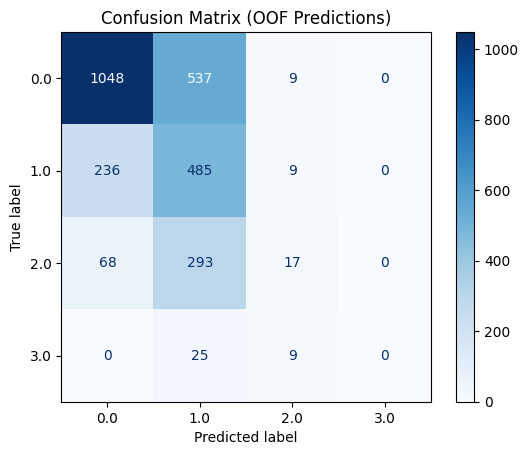

In [ ]:
# Count total misclassifications
misclassifications = np.sum(y != oof_rounded)
print(f"Total wrong validation predictions in train dataset: {misclassifications}")

# Final Classification Report
print("\nClassification Report (OOF Predictions):")
report = classification_report(y, oof_rounded, digits=4)
print(report)
with open("classification_report.txt", "w") as f:
    f.write(report)

# Confusion Matrix for Final OOF Predictions
conf_matrix = confusion_matrix(y, oof_rounded)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (OOF Predictions)")
plt.savefig("confusion_matrix_of_model.png")
plt.show()

**Confusion Matrix Analysis**

The confusion matrix evaluates model performance by comparing true labels and predicted labels across the entire training dataset (Out-of-Fold predictions).  

- **Diagonal values** represent correctly classified samples (e.g., 1048 samples in class 0, 485 samples in class 1).  
- **Off-diagonal values** indicate misclassifications (e.g., 537 samples from class 0 predicted as class 1, 68 samples from class 2 predicted as class 0).  

- **Class 0**:
  - **Precision**: 77.51%, **Recall**: 65.75%
  - Model performs well, with the highest metrics among all classes.
- **Class 1**:
  - **Precision**: 36.19%, **Recall**: 66.44%
  - Recall is higher, indicating over-classification for this class.
- **Class 2**:
  - **Precision**: 38.64%, **Recall**: 4.5%
  - Struggles significantly, failing to identify most samples.
- **Class 3**:
  - **Precision**: 0%, **Recall**: 0%
  - The model completely fails to recognize this class.

The model performs well on dominant classes (0 and 1) but fails on minority and borderline classes (2 and 3). Improvements in data balancing and feature engineering are needed to enhance performance.

The model made **1186 incorrect predictions** out of 2736 samples, achieving an accuracy of approximately **56.65%**.  
It performs better on classes 0 and 1 but struggles with adjacent class distinctions (e.g., between classes 0 and 1, 1 and 2).  

In [ ]:
submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
})

# Submission Model

In [ ]:
# Save submission
submission.to_csv('submission.csv', index=False)
print(submission['sii'].value_counts())

sii
0    9
1    8
2    3
Name: count, dtype: int64
